# Generate results from TTPs from an Excel sheet
This notebook depicts the third methodology for actor determination as described in the corresponding master thesis. Known operations are used as a measure to determine active threat actors. The actors will be ranked based on the date of the first operation, in order to detect whether an actor has just started, and the number of operations. These operations are weighted using an inverse weighting method, ranking recent operations higher. An alternative method is implemented in [Method 3.1](./Method%203_1.ipynb), where the ranking of actors is solely based on the number of operations.
A graphical representation is depicted in the image below.

The enriched data can then be filtered on the sector and the actors and TTPs will be ranked using the ranking functions. These ranked TTPs are then mapped to controls in order to obtain a prioritization of security controls. 

This notebook includes code for experiments on TTP subset sizes to be used in control prioritization. 

![Diagram representation of method 3](./docs/images/Method3.png)

## 1. Determine relevant threats  and actors
### 1.1. Read ETDA and MITRE data

In [72]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

SECTOR = 'Government'
SECTORS = ['Government', 'Education', 'Healthcare']

CONTROLS = "ISO_2013_NIST"

YEAR = datetime.date.today().year
YEAR = 2023
INTERVAL = 2
TTP_THRESHOLD = 0

import pandas as pd

# ttp_df = pd.read_excel('data/TTPS Ransomware from Kaspersky.xlsx',usecols=[1,2])
ttp_df = pd.read_excel('data/TTPS Ransomware Group-IB.xlsx')
ttp_df['ttp_weight'] = 1
ttp_df.columns = ['mitre_attack_ttps', 'ttp_weight']


In [73]:
ttp_df

,mitre_attack_ttps,ttp_weight
0,T1133,1
1,T1190,1
2,T1566,1
3,T1189,1
4,T1200,1
...,...,...
92,T1567,1
93,T1020,1
94,T1490,1
95,T1485,1


## 2. Rank actors and TTPs

### 2.2. Rank TTPs
#### 2.3.1 Explode dataframe per TTP
Explode the dataframe per TTP. Now a weighting calculation can be done per TTP, based on the information provided. Information includes the actor results (and kill chain phase).

For now: the actor weights are summed per TTP to obtain a ranking per TTP. 

#### 2.3.2. Group by TTP and sum actor weights
Sum the actor weights.

In [74]:
ttps_ranked = ttp_df
ttps_ranked.set_index('mitre_attack_ttps',inplace=True)
print(ttps_ranked.sort_values(by='ttp_weight',ascending=False))

                   ttp_weight
mitre_attack_ttps            
T1133                       1
T1069.002                   1
T1534                       1
T1550                       1
T1570                       1
...                       ...
T1222                       1
T1140                       1
T1197                       1
T1053                       1
T1486                       1

[97 rows x 1 columns]


#### 2.3.3 Enrich TTP information
Information from the ATT&CK data is used via the attackcti package.

In [75]:
from attackcti import attack_client
from pandas import json_normalize
import sys

mitre_columns = ['technique_id','technique','tactic','technique_detection']

def get_attck_dataframe(matrix = 'enterprise'):
    if  (matrix.lower() == 'enterprise'):
        # Instantiating attack_client class
        lift = attack_client()
        # Getting techniques for windows platform - enterprise matrix
        attck = lift.get_enterprise_techniques(stix_format = False)
        # Generating a dataframe with information collected
        attck = json_normalize(attck)
        return attck
    else:
        sys.exit('ERROR: Only Enterprise available!!')

attck = get_attck_dataframe()
attck = attck[mitre_columns]

ttps_enriched = pd.merge(ttps_ranked,attck,how='left',left_index=True,right_on='technique_id')
ttps_enriched.index = ttps_ranked.index
ttps_enriched['technique_name_id'] = ttps_enriched['technique'] + " (" + ttps_enriched['technique_id'] + ")"
ttps_enriched = ttps_enriched.drop(['technique_id'],axis=1)
ttps_enriched.index.value_counts()


[taxii2client.v20] [WARNING ] [2023-06-13 23:19:44,060] TAXII Server Response did not include 'Content-Range' header - results could be incomplete.
[taxii2client.v20] [WARNING ] [2023-06-13 23:19:44,140] TAXII Server Response with different amount of objects! Setting per_request=750


T1053    3
T1133    2
T1072    2
T1197    2
T1210    1
        ..
T1027    1
T1036    1
T1070    1
T1562    1
T1486    1
Name: mitre_attack_ttps, Length: 92, dtype: int64

#### Statistics

<AxesSubplot:title={'center':'Top 10 techniques for actors targeting Government sector'}, ylabel='TTP Name and ATT&CK ID'>

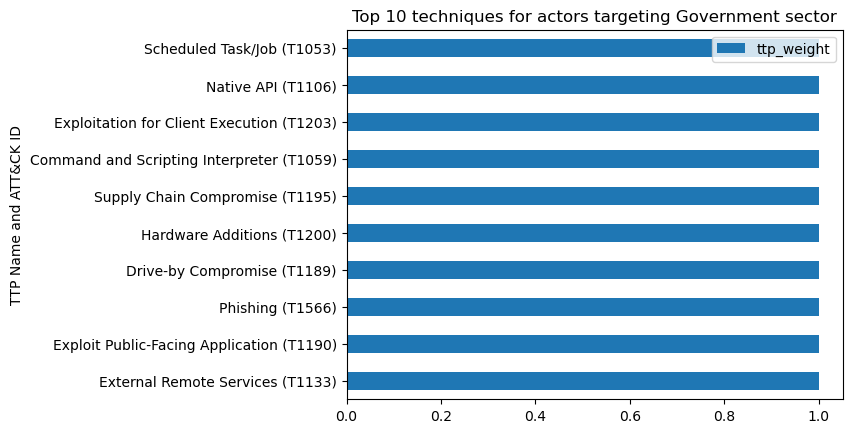

In [76]:
ttps_enriched.nlargest(10,columns='ttp_weight').plot.barh(y='ttp_weight',x='technique_name_id',xlabel="TTP Name and ATT&CK ID" ,title="Top 10 techniques for actors targeting {} sector".format(SECTOR))

Only take the top percentage of the TTPs

In [77]:
PERCENTAGE = 1

def take_percentage(percentage,df):
    top_percent = int(len(df) * PERCENTAGE)
    print("Taking {}%; {} entries".format(percentage*100,top_percent))
    return df.nlargest(top_percent,columns="ttp_weight")

def take_threshold(threshold, df):
    return df.loc[df['ttp_weight']>threshold]


ttps_enriched = take_percentage(PERCENTAGE,ttps_enriched)
ttps_enriched.sort_values(by="ttp_weight",inplace=True,ascending=False)
# ttps_enriched = take_threshold(TTP_THRESHOLD,ttps_enriched)

Taking 100%; 97 entries


#### Observations
Within the tested Government sector, the top 10 techniques used are shown above. 
The top technique is '[Obfuscated Files or Information](https://attack.mitre.org/techniques/T1027/)', where adversaries obfuscate the contents of an executable or file by encrypting, encoding, compressing or otherwise obscuring them on the system or in transit. This is common behavior to evade defenses. 

The second technique is '[Tool]'(https://attack.mitre.org/techniques/T1588/002/), is described as "Adversaries may buy, steal or download software tools that can be used during targeting." This is a very generic technique, since the use of the use of tools is common among hackers and there exists a wide variety of tools, hence why it is listed in such a high position.

## 3. Control prioritization

### 3.1 Control Mapping
Source of the mapping: [Security Control Framework Mappings to ATT&CK](https://github.com/center-for-threat-informed-defense/attack-control-framework-mappings).

This maps controls from NIST 800-53 to MITRE ATT&CK. The following versions are considered:
- MITRE ATT&CK v10.1
- NIST 800-53 Revision 5

In [78]:
# Load ATT&CK to NIST 800-53 mapping
def get_nist_attck_mapping():
    nist_attck_mapping = pd.read_excel("data/mappings/nist800-53-r5-mappings.xlsx")
    nist_attck_mapping = nist_attck_mapping.drop(["Mapping Type","Technique Name"],axis=1)
    return nist_attck_mapping

def get_cis_attck_mapping():
    return None

def get_iso_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2022_ATTCKv82.xlsx")
    return iso_attck_mapping

def get_nist_iso_2013_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2013_ATTCKv10.1_FROM_NIST.xlsx")
    return iso_attck_mapping

def get_cis_iso_2013_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2013_ATTCKv82.xlsx")
    return iso_attck_mapping

def get_cis7_iso_2013_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2013_ATTCKv82_FROM_CIS7.xlsx")
    return iso_attck_mapping

Merge the TTPs with the controls based on the selected framework. Remove controls which are expired.

In [79]:
ttp_control_map = get_iso_attck_mapping()
if CONTROLS == "ISO_2013_CIS":
    ttp_control_map = get_cis_iso_2013_attck_mapping()
elif CONTROLS == "ISO_2013_CIS7":
    ttp_control_map = get_cis7_iso_2013_attck_mapping()
elif CONTROLS == "ISO_2013_NIST":
    ttp_control_map = get_nist_iso_2013_attck_mapping()
elif CONTROLS == "ISO_2022":
    ttp_control_map = get_iso_attck_mapping()
elif CONTROLS == "NIST_SP_800_53":
    ttp_control_map = get_nist_attck_mapping()


ttp_control_merge = ttp_control_map.merge(ttps_enriched, left_on="Technique ID", right_on="mitre_attack_ttps",how="inner")
ttp_control_merge = ttp_control_merge.loc[ttp_control_merge["Control ID"] != '/']
ttp_control_merge = ttp_control_merge.loc[ttp_control_merge["Control Name"] != 'Vervallen']

ttp_control_merge.sort_values(by='ttp_weight',inplace=True,ascending=False)
print("Number of TTPS:",ttp_control_merge['Technique ID'].value_counts().index.size)
print("Number of controls:",ttp_control_merge['Control ID'].value_counts().index.size)
ttp_control_merge

Number of TTPS: 71
Number of controls: 68


,Control ID,Technique ID,Technique Name,Control Name,ttp_weight,technique,tactic,technique_detection,technique_name_id
0,A.11.2.8,T1021.001,Remote Desktop Protocol,Onbeheerde gebruikersapparatuur,1,Remote Desktop Protocol,[lateral-movement],"Use of RDP may be legitimate, depending on the...",Remote Desktop Protocol (T1021.001)
957,A.8.1.1,T1210,Exploitation of Remote Services,Inventariseren van bedrijfsmiddelen,1,Exploitation of Remote Services,[lateral-movement],Detecting software exploitation may be difficu...,Exploitation of Remote Services (T1210)
978,A.8.1.1,T1212,Exploitation for Credential Access,Inventariseren van bedrijfsmiddelen,1,Exploitation for Credential Access,[credential-access],Detecting software exploitation may be difficu...,Exploitation for Credential Access (T1212)
977,A.18.2.2,T1212,Exploitation for Credential Access,Naleving van beveiligingsbeleid en -normen,1,Exploitation for Credential Access,[credential-access],Detecting software exploitation may be difficu...,Exploitation for Credential Access (T1212)
976,9.1,T1212,Exploitation for Credential Access,NaN,1,Exploitation for Credential Access,[credential-access],Detecting software exploitation may be difficu...,Exploitation for Credential Access (T1212)
...,...,...,...,...,...,...,...,...,...
484,A.6.2.1,T1133,External Remote Services,Beleid voor mobiele apparatuur,1,External Remote Services,"[persistence, initial-access]",Follow best practices for detecting adversary ...,External Remote Services (T1133)
483,A.12.2.1,T1059,Command and Scripting Interpreter,Beheersmaatregelen tegen malware,1,Command and Scripting Interpreter,[execution],Command-line and scripting activities can be c...,Command and Scripting Interpreter (T1059)
482,A.16.1.3,T1059,Command and Scripting Interpreter,Rapportage van zwakke plekken in de informatie...,1,Command and Scripting Interpreter,[execution],Command-line and scripting activities can be c...,Command and Scripting Interpreter (T1059)
480,A.14.2.2,T1059,Command and Scripting Interpreter,Procedures voor wijzigingsbeheer met betrekkin...,1,Command and Scripting Interpreter,[execution],Command-line and scripting activities can be c...,Command and Scripting Interpreter (T1059)


Get TTPs incl number of controls that mitigate them

<AxesSubplot:title={'center':'Distribution of TTP weights for actors targeting Government sector'}, ylabel='Frequency'>

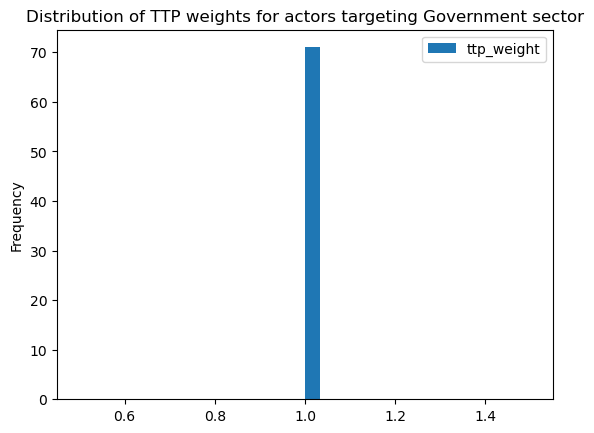

In [80]:
ttp_control_merge[['Technique ID','ttp_weight']].drop_duplicates().plot(kind='hist',bins=30,title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR))
# ttp_control_merge['ttp_weight'].plot(kind='hist',bins=30,title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR),xlabel="TTP weights")

**Observations**

The TTP weights are a normalised summation of the actor weights. This means, the higher the TTP weight, the more (high weighted) actors share this TTP.
We can see that the distribution of TTP weights is a right-skewed distribution. This is expected, since this means that the number of TTPs that are shared by these actors is 

<AxesSubplot:title={'center':'Top controls by number of mitigated TTPs. Top 100% of TTPS'}, ylabel='Control ID,Control Name'>

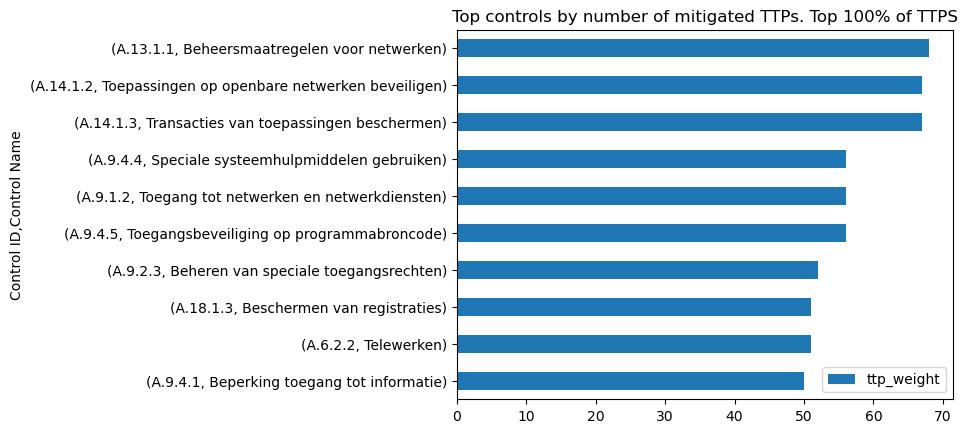

In [88]:
# ttp_control_merge[['Control ID','Control Name']].value_counts().nlargest(10).plot(kind='barh',title="Number of selected TTPs mitigated per control")

ttp_control_ranked = ttp_control_merge.groupby(['Control ID','Control Name']).sum()
ttp_control_ranked.sort_values(by='ttp_weight',ascending=False, inplace=True)

# ttp_control_ranked.nlargest(10,columns='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. No TTP threshold")
ttp_control_ranked.nlargest(10,columns='ttp_weight').sort_values(by='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. Top {}% of TTPS".format(PERCENTAGE*100))

In [82]:
ttp_control_ranked

,,ttp_weight
Control ID,Control Name,
A.13.1.1,Beheersmaatregelen voor netwerken,68
A.14.1.3,Transacties van toepassingen beschermen,67
A.14.1.2,Toepassingen op openbare netwerken beveiligen,67
A.9.4.5,Toegangsbeveiliging op programmabroncode,56
A.9.1.2,Toegang tot netwerken en netwerkdiensten,56
...,...,...
A.13.2.2,Overeenkomsten over informatietransport,1
A.13.1.2,Beveiliging van netwerkdiensten,1
A.11.2.9,‘Clear desk’- en ‘clear screen’-beleid,1


#### Observations
There are some controls that map to a lot of TTPs. For the complete results for the ‘Government’ sector, there are 215 TTPs and 106 controls. Merging the two gives a resulting set of 2545 mappings. Since there is no measure of control effectiveness to a TTP in this data, they are sorted based on the TTPs they control and their respective weights.

There are two ways to approach the control mapping, either a generic approach or a targeted approach.
- Targeted: Take the most prominent TTPs, those with the highest weights, and display the controls for this. 
- Generic: Take the complete, or near-complete, set of TTPs used by the actors. Rank the controls based on the number of TTPs they control and their respective weights. The downside of this is that controls that map to a large number of TTPs will probably always end up on top. This means that the initial TTP ranking matters less.

When simply counting the number of TTPs that a control covers, only the general ones come to the top. Even if the TTP weights are considered. One possibility to solve this, is to only take the top x% of TTPs into consideration.

# Get TTPs mitigated by said control

In [83]:
control_id = "A.13.1.1"
ttp_control_merge.loc[ttp_control_merge['Control ID'] == control_id]

,Control ID,Technique ID,Technique Name,Control Name,ttp_weight,technique,tactic,technique_detection,technique_name_id
980,A.13.1.1,T1212,Exploitation for Credential Access,Beheersmaatregelen voor netwerken,1,Exploitation for Credential Access,[credential-access],Detecting software exploitation may be difficu...,Exploitation for Credential Access (T1212)
996,A.13.1.1,T1218,Signed Binary Proxy Execution,Beheersmaatregelen voor netwerken,1,System Binary Proxy Execution,[defense-evasion],Monitor processes and command-line parameters ...,System Binary Proxy Execution (T1218)
943,A.13.1.1,T1210,Exploitation of Remote Services,Beheersmaatregelen voor netwerken,1,Exploitation of Remote Services,[lateral-movement],Detecting software exploitation may be difficu...,Exploitation of Remote Services (T1210)
1058,A.13.1.1,T1556,Modify Authentication Process,Beheersmaatregelen voor netwerken,1,Modify Authentication Process,"[credential-access, defense-evasion, persistence]","Monitor for new, unfamiliar DLL files written ...",Modify Authentication Process (T1556)
1088,A.13.1.1,T1562,Impair Defenses,Beheersmaatregelen voor netwerken,1,Impair Defenses,[defense-evasion],Monitor processes and command-line arguments t...,Impair Defenses (T1562)
...,...,...,...,...,...,...,...,...,...
406,A.13.1.1,T1021.006,Windows Remote Management,Beheersmaatregelen voor netwerken,1,Windows Remote Management,[lateral-movement],Monitor use of WinRM within an environment by ...,Windows Remote Management (T1021.006)
456,A.13.1.1,T1059,Command and Scripting Interpreter,Beheersmaatregelen voor netwerken,1,Command and Scripting Interpreter,[execution],Command-line and scripting activities can be c...,Command and Scripting Interpreter (T1059)
530,A.13.1.1,T1219,Remote Access Software,Beheersmaatregelen voor netwerken,1,Remote Access Software,[command-and-control],Monitor for applications and processes related...,Remote Access Software (T1219)
489,A.13.1.1,T1133,External Remote Services,Beheersmaatregelen voor netwerken,1,External Remote Services,"[persistence, initial-access]",Follow best practices for detecting adversary ...,External Remote Services (T1133)


# Port to ISO 27002:2013

In [84]:
# iso_2022_2013 = pd.read_excel("data/mappings/ISO_27001_2022_2013.xlsx")

# ttp_control_ranked_2013 = ttp_control_ranked.merge(iso_2022_2013,left_index=True,right_on='Control-nr. 2022',how="left")
# ttp_control_ranked_2013.drop(['Control-nr. 2022'],axis=1,inplace=True)
# ttp_control_ranked_2013 = ttp_control_ranked_2013.drop_duplicates()
# ttp_control_ranked_2013 = ttp_control_ranked_2013.groupby(['Control-nr. 2013', 'Control-Name 2013']).sum()

# ttp_control_ranked_2013.sort_values(by='ttp_weight',ascending=False)
# ttp_control_ranked_2013.to_excel("Ranked controls to ISO 2013.xlsx")

# ttp_control_ranked_2013 = ttp_control_ranked_2013.drop_duplicates()
# ttp_control_ranked_2013.to_excel("Ranked controls to ISO 2013 RM duplicates.xlsx")



# Export results
Export the results to an excel with three sheets:
- Actors
- TTPs
- Controls

In [85]:
writer = pd.ExcelWriter("results/{} Result Sheet ransomware TTPs.xlsx".format(CONTROLS),engine="xlsxwriter")

ttp_control_ranked.to_excel(writer,sheet_name="Controls")
ttp_control_merge.to_excel(writer,sheet_name="TTP and Control mitigations",index=False)
ttps_enriched.to_excel(writer,sheet_name="TTPs")

writer.close()